# Imports

In [ ]:
#Import libraries
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Προετοιμασία δεδομένων

In [ ]:
#Download NN image classification model (any other (differential-learning) NN can be used instead)
model = tf.keras.Sequential([
    hub.KerasLayer(
        # name='inception_v1',
        # handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        # name='inception_v2',
        # handle='https://tfhub.dev/google/imagenet/inception_v2/classification/5',
        # name='inception_v3',
        # handle='https://tfhub.dev/google/imagenet/inception_v3/classification/5',
        name='inception_resnet_v2',
        handle='https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (KerasL  (None, 1001)             55875273  
 ayer)                                                           
                                                                 
Total params: 55,875,273
Trainable params: 0
Non-trainable params: 55,875,273
_________________________________________________________________


In [ ]:
#Import labels from Imagenet dataset
def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

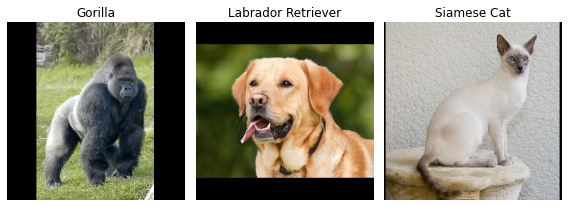

In [ ]:
#Import and visualize input images (any image can be used instead), assumed in jpg format
def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

img_url = {
    'Gorilla': 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Gorille_des_plaines_de_l%27ouest_%C3%A0_l%27Espace_Zoologique.jpg/800px-Gorille_des_plaines_de_l%27ouest_%C3%A0_l%27Espace_Zoologique.jpg' ,
    'Labrador Retriever': 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Labrador_Retriever_%281210559%29.jpg/300px-Labrador_Retriever_%281210559%29.jpg' ,
    'Siamese Cat': 'https://upload.wikimedia.org/wikipedia/commons/2/25/Siam_lilacpoint.jpg'
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 3, n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Perform image classification (generate top-k most probable predictions)
def top_k_predictions(img, k=5):
    image_batch = tf.expand_dims(img, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0], top_idxs[0]

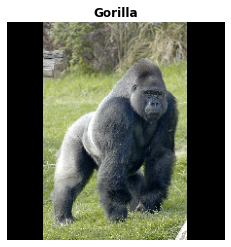

gorilla (concept index: 367): 100.0%
chimpanzee (concept index: 368): 0.0%
orangutan (concept index: 366): 0.0%
siamang (concept index: 370): 0.0%
baboon (concept index: 373): 0.0%


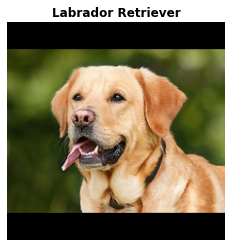

Labrador retriever (concept index: 209): 99.5%
golden retriever (concept index: 208): 0.5%
tennis ball (concept index: 853): 0.0%
flat-coated retriever (concept index: 206): 0.0%
Chesapeake Bay retriever (concept index: 210): 0.0%


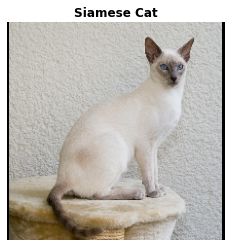

Siamese cat (concept index: 285): 100.0%
lynx (concept index: 288): 0.0%
Egyptian cat (concept index: 286): 0.0%
cougar (concept index: 287): 0.0%
tabby (concept index: 282): 0.0%


In [ ]:
#Visualize classification results
for (name, img_tensor) in img_name_tensors.items():
    plt.imshow(img_tensor)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()

    pred_label, pred_prob, pred_idx = top_k_predictions(img_tensor)
    for label, prob, idx in zip(pred_label, pred_prob, pred_idx):
        print(f'{label} (concept index: {idx}): {prob:0.1%}')

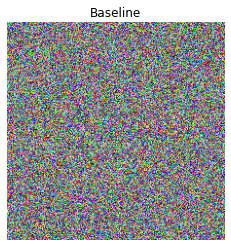

In [ ]:
#Apply 'Integrated Gradients' XAI method

#Define baseline image for explanations generation
# baseline = tf.zeros(shape=(224,224,3))                                             #black
# baseline = tf.ones(shape=(224,224,3))                                              #white
baseline = tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)            #random

plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [ ]:
#Interpolation between baseline and original image
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation()
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    return images

In [ ]:
#Calculation of gradients
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [ ]:
#Integral approximation of gradient accumulation
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [ ]:
#Execution of actual 'Integrated Gradients' method
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
    # Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Collect gradients.
    gradient_batches = []

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]
        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    # Concatenate path gradients together row-wise into single tensor.
    total_gradients = tf.concat(gradient_batches, axis=0)

    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [ ]:
#Optimized processing pipeline
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)
    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [ ]:
#Visualize Integrated Gradients output
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = integrated_gradients(baseline=baseline,
                                        image=image,
                                        target_class_idx=target_class_idx,
                                        m_steps=m_steps)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

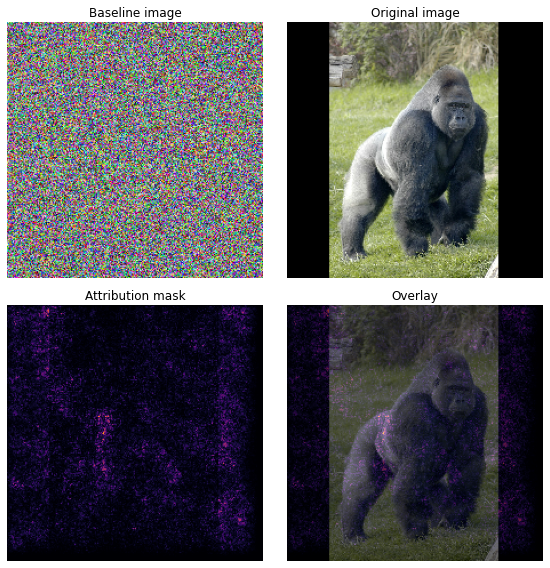

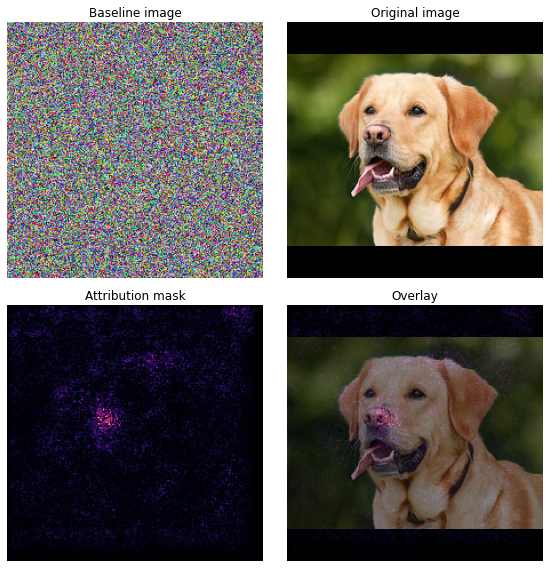

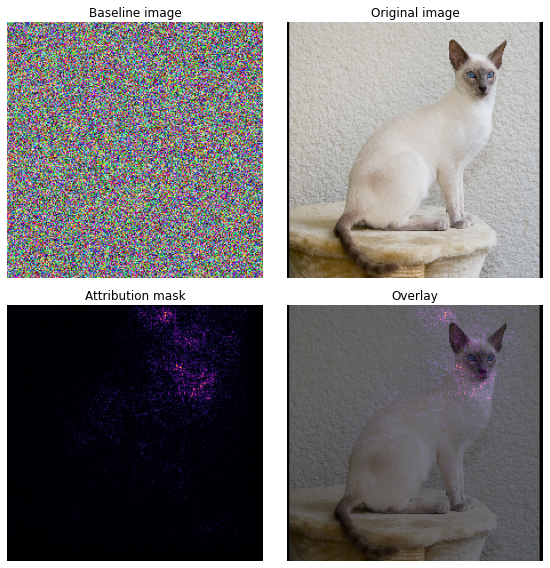

In [ ]:
_ = plot_img_attributions(image=img_name_tensors['Gorilla'],
baseline=baseline,
target_class_idx=555,
m_steps=240,
cmap=plt.cm.inferno,
overlay_alpha=0.4)

_ = plot_img_attributions(image=img_name_tensors['Labrador Retriever'],
baseline=baseline,
target_class_idx=389,
m_steps=55,
cmap=plt.cm.inferno,
overlay_alpha=0.5)

_ = plot_img_attributions(image=img_name_tensors['Siamese Cat'],
baseline=baseline,
target_class_idx=285,
m_steps=55,
cmap=plt.cm.inferno,
overlay_alpha=0.5)